In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [29]:
DEVICE = "mps"
SAMPLE_RATE = 22050
N_MELS = 64
MAX_LEN = 173
NUM_CLASSES = 10


In [30]:
import soundfile as sf

class UrbanSoundDataset(Dataset):
    def __init__(self, csv_file, audio_dir):
        self.df = pd.read_csv(csv_file)
        self.audio_dir = audio_dir

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_mels=N_MELS
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def _pad_or_crop(self, spec):
        if spec.shape[1] < MAX_LEN:
            pad = MAX_LEN - spec.shape[1]
            spec = F.pad(spec, (0, pad))
        else:
            spec = spec[:, :MAX_LEN]
        return spec

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(
            self.audio_dir,
            f"fold{row.fold}",
            row.slice_file_name
        )

        waveform, sr = sf.read(path)   # ← ВАЖНО
        if waveform.ndim > 1:
            waveform = waveform.mean(axis=1)

        waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)

        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(
                waveform, sr, SAMPLE_RATE
            )

        spec = self.mel(waveform)
        spec = self.amplitude_to_db(spec)
        spec = spec.squeeze(0)
        spec = self._pad_or_crop(spec)

        label = row.classID
        return spec, label


In [31]:
class ConvTime(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(N_MELS, 128, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.pool2 = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        # x: (B, freq, time)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.squeeze(-1)
        return self.fc(x)


In [32]:
class ConvFreq(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(MAX_LEN, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        # x: (B, freq, time) → (B, time, freq)
        x = x.transpose(1, 2)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.squeeze(-1)
        return self.fc(x)


In [33]:
class ConvTimeFreq(nn.Module):
    def __init__(self):
        super().__init__()

        self.freq_conv = nn.Conv1d(MAX_LEN, 128, kernel_size=3, padding=1)
        self.time_conv = nn.Conv1d(128, 256, kernel_size=5, padding=2)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.freq_conv(x))

        x = F.relu(self.time_conv(x))
        x = self.pool(x)

        x = x.squeeze(-1)
        return self.fc(x)


In [34]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [35]:
def eval_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            out = model(x)
            preds = out.argmax(dim=1).cpu()

            y_true.extend(y.tolist())
            y_pred.extend(preds.tolist())

    return classification_report(y_true, y_pred, output_dict=True)


In [36]:
dataset = UrbanSoundDataset(
    csv_file="archive-2/UrbanSound8K.csv",
    audio_dir="archive-2"
)

train_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.df["classID"]
)

train_loader = DataLoader(
    torch.utils.data.Subset(dataset, train_idx),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    torch.utils.data.Subset(dataset, test_idx),
    batch_size=32
)


In [37]:
def train_and_evaluate(model, name, epochs=10):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        train_epoch(model, train_loader, optimizer, criterion)

    report = eval_model(model, test_loader)

    return {
        "model": name,
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"],
        "per_class": report
    }



In [23]:
model_time = ConvTime()
model_freq = ConvFreq()
class ConvFreqTime(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq = nn.Conv1d(MAX_LEN, 128, 3, padding=1)
        self.time = nn.Conv1d(128, 256, 5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.freq(x))
        x = F.relu(self.time(x))
        x = self.pool(x)
        return self.fc(x.squeeze(-1))

class ConvParallel(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_conv = nn.Sequential(
            nn.Conv1d(N_MELS, 128, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.freq_conv = nn.Sequential(
            nn.Conv1d(MAX_LEN, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.fc = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        t = self.time_conv(x).squeeze(-1)
        f = self.freq_conv(x.transpose(1, 2)).squeeze(-1)
        return self.fc(torch.cat([t, f], dim=1))



In [24]:
results = []

for model, name in [
    (model_time, "ConvTime"),
    (model_freq, "ConvFreq"),
    (ConvFreqTime(), "ConvFreq→Time"),
    (ConvParallel(), "Parallel Time+Freq")
]:
    print(f"\nTraining {name}")
    res = train_and_evaluate(model, name)
    results.append(res)



Training ConvTime

Training ConvFreq

Training ConvFreq→Time

Training Parallel Time+Freq


In [25]:
summary = pd.DataFrame([
    {
        "Model": r["model"],
        "Accuracy": r["accuracy"],
        "Macro F1": r["macro_f1"],
        "Weighted F1": r["weighted_f1"]
    }
    for r in results
])

summary


,Model,Accuracy,Macro F1,Weighted F1
0,ConvTime,0.824843,0.835538,0.825856
1,ConvFreq,0.630796,0.648258,0.629065
2,ConvFreq→Time,0.645106,0.666067,0.648493
3,Parallel Time+Freq,0.733829,0.737068,0.718903


In [26]:
class_tables = {}

for r in results:
    df = pd.DataFrame(r["per_class"]).T
    class_tables[r["model"]] = df.loc[
        [str(i) for i in range(10)], ["f1-score"]
    ].rename(columns={"f1-score": r["model"]})

pd.concat(class_tables.values(), axis=1)


,ConvTime,ConvFreq,ConvFreq→Time,Parallel Time+Freq
0,0.843902,0.564315,0.555773,0.750594
1,0.890244,0.700637,0.681319,0.811765
2,0.689189,0.572072,0.578089,0.614699
3,0.809278,0.580046,0.652291,0.735000
4,0.850136,0.625287,0.668258,0.756627
5,0.855107,0.726437,0.673854,0.749455
6,0.921053,0.866667,0.899329,0.916129
7,0.933985,0.725275,0.707865,0.881013
8,0.834734,0.666667,0.652174,0.796834
9,0.727749,0.455172,0.591716,0.358566


In [39]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())

    return np.array(all_labels), np.array(all_preds)


In [40]:
labels, preds = get_predictions(model_time, test_loader)

cm = confusion_matrix(labels, preds)

print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (10, 10)


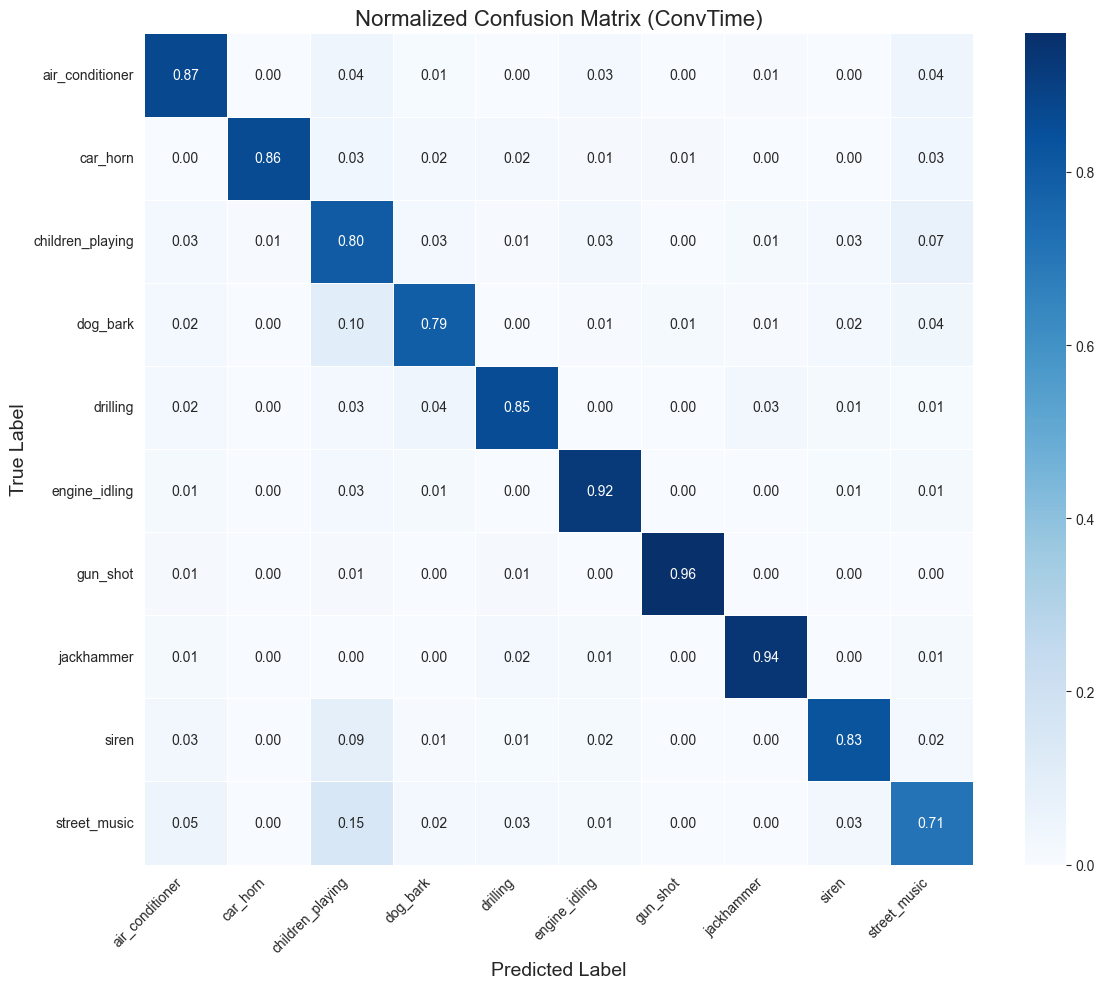

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Получаем предсказания
labels, preds = get_predictions(model_time, test_loader)

cm = confusion_matrix(labels, preds)

# Нормализация (по строкам)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

plt.figure(figsize=(12, 10))

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5
)

plt.title("Normalized Confusion Matrix (ConvTime)", fontsize=16)
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


1D-свёртка по времени демонстрируют наилучшие результаты для датасета UrbanSound8K